# Create inputs for a variable-coefficient KdV run from the climatology atlas

Steps:
---

    1. Input a transect and time period
    2. Extract the topography along the line
    3. Extract the buoyancy along the line
    4. Extract a time-series of internal tide amplitude moving onto the shelf
    
    

In [1]:
from iwatlas import sshdriver
from iwatlas import harmonics
import iwatlas.stratification as strat
from iwatlas import iwaves



import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, RectBivariateSpline

import matplotlib.pyplot as plt

In [2]:
basedir = '/home/suntans/cloudstor/Data/IWAtlas'


# climfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Climatology.nc'.format(basedir)
N2file = '{}/NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas_v2.1.nc'.format(basedir)
sshfile = '{}/NWS_2km_GLORYS_hex_2013_2014_SSHBC_Harmonics.nc'.format(basedir)


ssh_ds = sshdriver.load_ssh_clim(sshfile)
N2_ds = sshdriver.load_ssh_clim(N2file)
N2_ds

<xarray.Dataset>
Dimensions:  (Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 7, Ntide: 4, numsides: 8, time: 23)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
    xv       (Nc) float64 ...
    yv       (Nc) float64 ...
    Nk       (Nc) int32 ...
    z_w      (Nkw) float64 ...
    omega    (Ntide) float64 ...
    params   (Nparams) int64 ...
Dimensions without coordinates: Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp       (Np) float64 1.394e+07 1.271e+07 1.517e+07 ... 1.303e+07 1.303e+07
    yp       (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces   (Nc) int32 ...
    dv       (Nc) float64 ...
    modes    (Nmode) float64 ...
    dz       (Nk) float64 ...
    z_r      (Nk) float64 ...
    N2_t     (time, Nparams, Nc) float64 ...
    N2_mu    (Nparams, Nc) float64 ...
    N2_re    (Ntide, Nparams, Nc) float64 .

In [3]:
######
# Specify a start and end point and draw on a map

## WEL Bathy Prelude transect
x0 = 122.753
y0 = -13.1026

x1 = 123.486
y1 = -13.947

# Prelude point
xpt = 123.3506
ypt = -13.7641

dx = 0.01 # ~1km
######

In [4]:
## Generate x and y slice coordinates
lon = np.arange(x0, x1, dx)
Fx = interp1d([x0,x1],[y0,y1])
lat = Fx(lon)

(-15.7641, -11.7641)

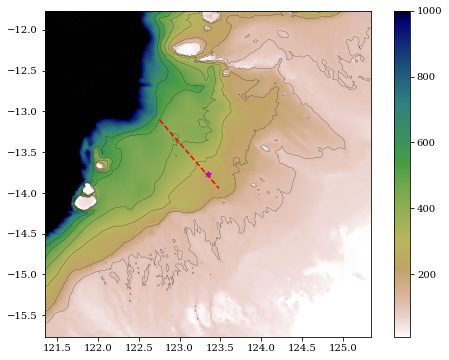

In [5]:
plt.figure(figsize=(8,6))
N2_ds.plotcelldata(N2_ds._ds.dv, vmax=1000, cmap='gist_earth_r')
N2_ds.contourf(N2_ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.xlim(xpt-2, xpt+2)
plt.ylim(ypt-2, ypt+2)

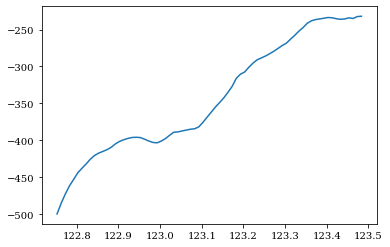

In [6]:
# Interpolate the bathy along the line
hbathy = N2_ds.interpolate(N2_ds._ds.dv, lon, lat)

plt.figure()
plt.plot(lon, -hbathy)

In [7]:
# Interpolate the buoyancy frequency along the line

timept = np.array([
    np.datetime64('2017-03-30 00:00:00'),
    np.datetime64('2017-03-01 00:00:00'),
    np.datetime64('2016-08-01 00:00:00'),

    ])
Nz = 80

N2_z, zout = strat.predict_N2(N2file, lon ,lat, timept,  Nz)

/home/suntans/code/iwatlas/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


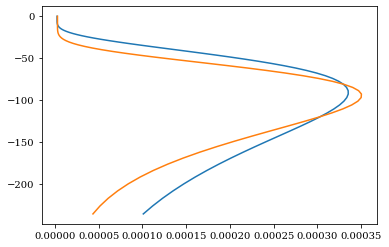

In [8]:
# Plot the buoyancy frequency at the first point in space
idx = 67
plt.figure()
plt.plot(N2_z[:,idx,0], -zout[:,idx,0],)
plt.plot(N2_z[:,idx,1], -zout[:,idx,1],)

In [9]:
# Calculate the internal wave parameters
phi_n, cn = iwaves.calc_modes(N2_z, zout)
alpha = iwaves.calc_alpha(phi_n, cn, zout)
beta = iwaves.calc_beta(phi_n, cn, zout)
ampratio = iwaves.ssh_to_amp_ratio(N2_z, phi_n, zout)
sshratio = iwaves.amp_to_ssh_ratio(N2_z, phi_n, zout)

(0, 30000.0)

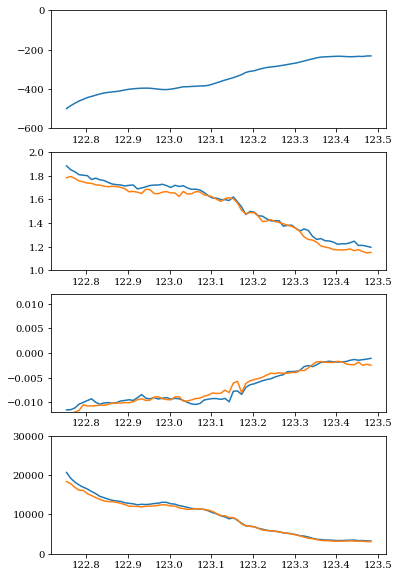

In [10]:
plt.figure(figsize=(6,10))
plt.subplot(411)
plt.plot(lon, -hbathy)
plt.ylim(-600,0)

plt.subplot(412)
plt.plot(lon, cn[:,0])
plt.plot(lon, cn[:,1])

plt.ylim(1,2)

plt.subplot(413)
plt.plot(lon, alpha[:,0])
plt.plot(lon, alpha[:,1])

plt.ylim(-0.012, 0.012)

plt.subplot(414)
plt.plot(lon, beta[:,0])
plt.plot(lon, beta[:,1])
plt.ylim(0,3e4)

In [11]:
# Extract the slowly-varying amplitudes for all space but one point in time

xyrange = 2.5
xlims = (x0-xyrange, x0+xyrange)
ylims = (y0-xyrange, y0+xyrange)



# Filtering bands (degrees CCW from East)
thetalow = 270
thetahigh = 335


# thetalow = 60
# thetahigh = 120
#######

A_re_f, A_im_f, A_re, A_im, X, Y = sshdriver.extract_amp_nonstat_dff(ssh_ds, xlims, ylims, dx, timept,\
                    thetalow, thetahigh, A_re=None, A_im=None)

In [12]:
frq=0
z = A_re[frq,0,...] + 1j*A_im[frq,0,...]
zf = A_re_f[frq,0,...] + 1j*A_im_f[frq,0,...]

(-15.6026, -10.6026)

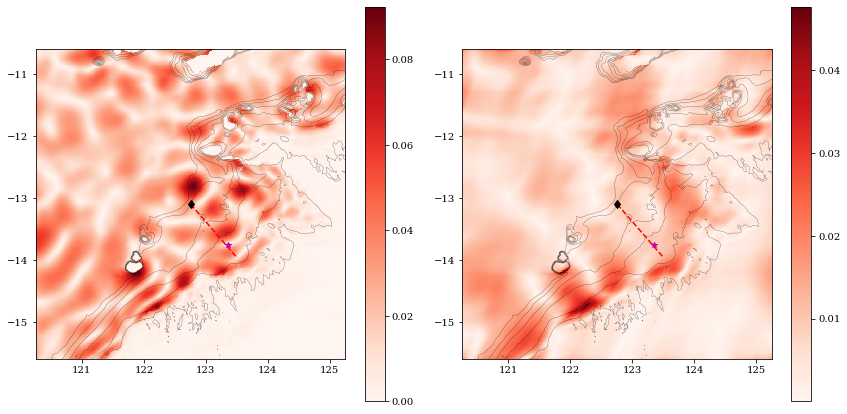

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(X,Y,np.abs(z), cmap='Reds')
plt.colorbar()
plt.gca().set_aspect('equal')
N2_ds.contourf(N2_ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x0,y0,'kd')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(zf), cmap='Reds')
plt.colorbar()
plt.tight_layout()
plt.gca().set_aspect('equal')
N2_ds.contourf(N2_ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x0,y0,'kd')
plt.xlim(xlims)
plt.ylim(ylims)


(-15.6026, -10.6026)

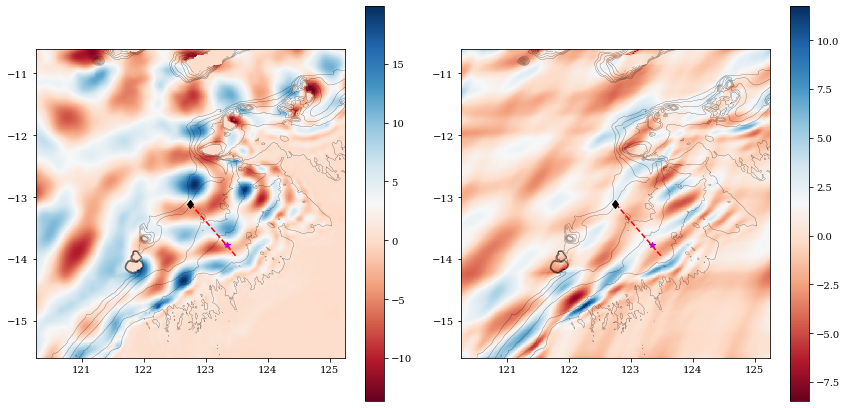

In [14]:
scalefac = sshratio.mean() # ~250:1 ssh:amplitude ratio

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(X,Y,np.real(z)*scalefac, cmap='RdBu')
plt.colorbar()
plt.gca().set_aspect('equal')
N2_ds.contourf(N2_ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x0,y0,'kd')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(122)
plt.pcolormesh(X,Y,np.real(zf)*scalefac, cmap='RdBu')
plt.colorbar()
plt.tight_layout()
plt.gca().set_aspect('equal')
N2_ds.contourf(N2_ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x0,y0,'kd')
plt.xlim(xlims)
plt.ylim(ylims)


In [15]:
# Extract amplitude at a point
dt = 1800
nsteps = 15*86400//dt
timeout = [timept[0]+np.timedelta64(ii*dt,'s') for ii in range(nsteps)]

ssh_SE = sshdriver.extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 290, 360, xyrange=2.0, dx=0.02 )
ssh_NW = sshdriver.extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 290-180, 360-180, xyrange=2.0, dx=0.02 )

# # Calculate a time series of ssh at the point without DFF
ssh_pt = sshdriver.predict_ssh(sshfile, x0, y0, timeout)

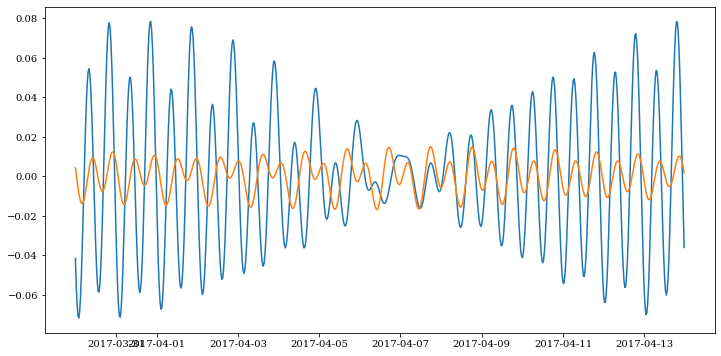

In [16]:
plt.figure(figsize=(12,6))
plt.plot(timeout, ssh_pt)
plt.plot(timeout, ssh_SE)

---
# Testing code

In [39]:
# Interpolate the DFF result back onto the point of interest
nf, nt, ny, nx = A_re.shape

A_re_pt = np.zeros((nf,nt))
A_im_pt = np.zeros((nf,nt))
for ff in range(nf):
    for ii in range(nt):
        F = RectBivariateSpline( Y[:,0], X[0,:], A_re_f[ff,ii,...])
        A_re_pt[ff,ii] = F(y0,x0)
        F = RectBivariateSpline( Y[:,0], X[0,:], A_im_f[ff,ii,...])
        A_im_pt[ff,ii] = F(y0,x0)

In [40]:
# Generate a time-series using amplitudes from the first time steps only
omegaall = ssh_ds._ds.omega.values
na = 3
ntide = 5
# Location of the main tidal frequencies
ii = [(ff+1)*(2*na+1)-na-1 for ff in range(ntide)]
omega = omegaall[ii]
reftime = np.datetime64(ssh_ds._ds.attrs['ReferenceDate'])


dt = 1800
nsteps = 15*86400//dt
timeout = [timept[0]+np.timedelta64(ii*dt,'s') for ii in range(nsteps)]

tsec = (timeout - reftime).astype('timedelta64[s]').astype(float)
omega,ii
ssh_pt_f = harmonics.harmonic_pred(0, A_re_pt[:,0], A_im_pt[:,0], omega, tsec)

In [41]:
# # Calculate a time series of ssh at the point
ssh_pt = sshdriver.predict_ssh(sshfile, x0, y0, timeout)

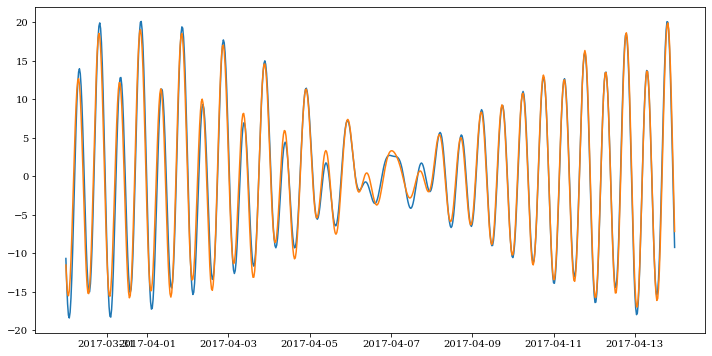

In [42]:
plt.figure(figsize=(12,6))
plt.plot(timeout, ssh_pt*scalefac)
plt.plot(timeout, ssh_pt_f*scalefac)

In [77]:
ssh_SE = extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 290, 360, xyrange=2.0, dx=0.02 )
ssh_NW = extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 290-180, 360-180, xyrange=2.0, dx=0.02 )

#ssh_ALL = extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 0, 290, xyrange=2.0, dx=0.02 )

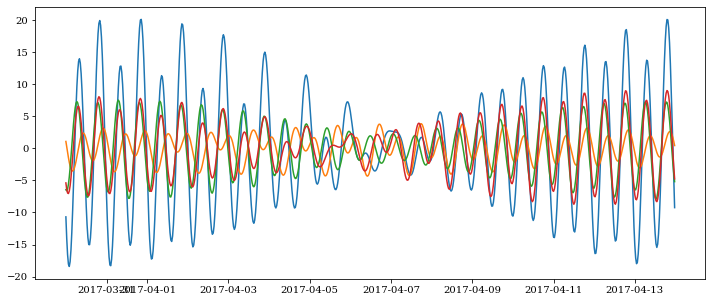

In [79]:

plt.figure(figsize=(12,5))
plt.plot(timeout, ssh_pt*scalefac)
plt.plot(timeout, ssh_SE*scalefac)
plt.plot(timeout, ssh_NW*scalefac)

plt.plot(timeout, (ssh_SE+ssh_NW)*scalefac)

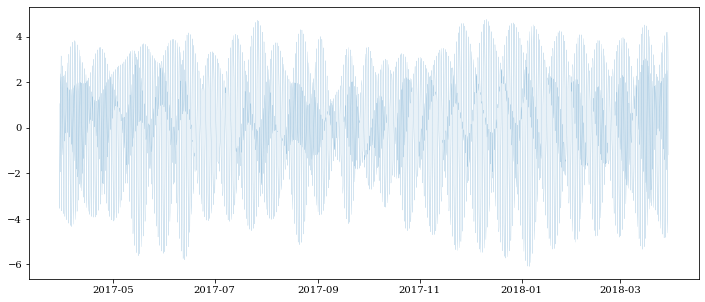

In [82]:
dt = 1800
nsteps = 365*86400//dt
timeout = [timept[0]+np.timedelta64(ii*dt,'s') for ii in range(nsteps)]
ssh_SE = extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 290, 360, xyrange=2.0, dx=0.02 )
ssh_NW = extract_ssh_point_dff(ssh_ds, x0, y0, timeout, 290-180, 360-180, xyrange=2.0, dx=0.02 )

plt.figure(figsize=(12,5))
plt.plot(timeout, ssh_SE*scalefac, lw=0.1)
# plt.plot(timeout, ssh_NW*scalefac)